In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url,
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


In [4]:
def analise_bivariada(df, var_resposta, var_explicativa):
    # Criando a tabela bivariada
    bivariada = df.groupby(var_explicativa)[var_resposta].agg(['sum', 'count']).reset_index()
    bivariada.columns = [var_explicativa, 'doentes', 'total']
    bivariada['saudaveis'] = bivariada['total'] - bivariada['doentes']

    # Calculando as estatísticas adicionais
    bivariada['prop_doentes'] = bivariada['doentes'] / bivariada['total']
    bivariada['odds'] = bivariada['doentes'] / bivariada['saudaveis']
    bivariada['odds_ratio'] = bivariada['odds'] / bivariada['odds'].mean()
    bivariada['logito'] = np.log(bivariada['odds'])
    bivariada['woe'] = np.log(bivariada['odds_ratio'])

    # Adicionando o total geral
    total_geral = bivariada[['saudaveis', 'doentes', 'total']].sum().to_frame().T
    total_geral[var_explicativa] = 'Total'
    total_geral['prop_doentes'] = total_geral['doentes'] / total_geral['total']
    total_geral['odds'] = total_geral['doentes'] / total_geral['saudaveis']
    total_geral['odds_ratio'] = 1
    total_geral['logito'] = np.log(total_geral['odds'])
    total_geral['woe'] = 0

    # Concatenando o total geral com a tabela bivariada
    bivariada_final = pd.concat([bivariada, total_geral], ignore_index=True)

    # Reordenando as colunas
    colunas_ordem = [var_explicativa, 'saudaveis', 'doentes', 'total', 'prop_doentes', 'odds', 'odds_ratio', 'logito', 'woe']
    bivariada_final = bivariada_final[colunas_ordem]

    return bivariada_final

# Analisando três variáveis qualitativas
variaveis = ['sex', 'cp', 'fbs']

for var in variaveis:
    print(f"\nAnálise bivariada para a variável: {var}")
    resultado = analise_bivariada(df, 'flag_doente', var)
    print(resultado.to_string(index=False))
    print("\n" + "="*80)


Análise bivariada para a variável: sex
  sex  saudaveis  doentes  total  prop_doentes     odds  odds_ratio    logito       woe
  0.0         72       25     97      0.257732 0.347222    0.437762 -1.057790 -0.826081
  1.0         92      114    206      0.553398 1.239130    1.562238  0.214410  0.446120
Total        164      139    303      0.458746 0.847561    1.000000 -0.165392  0.000000


Análise bivariada para a variável: cp
   cp  saudaveis  doentes  total  prop_doentes     odds  odds_ratio    logito       woe
  1.0         16        7     23      0.304348 0.437500    0.484225 -0.826679 -0.725207
  2.0         41        9     50      0.180000 0.219512    0.242956 -1.516347 -1.414875
  3.0         68       18     86      0.209302 0.264706    0.292976 -1.329136 -1.227664
  4.0         39      105    144      0.729167 2.692308    2.979843  0.990399  1.091871
Total        164      139    303      0.458746 0.847561    1.000000 -0.165392  0.000000


Análise bivariada para a variável: fbs

In [5]:

def analise_bivariada_continua(df, var_resposta, var_explicativa, num_categorias=5):
    # Categorizando a variável explicativa
    df_temp = df.copy()
    df_temp[f'{var_explicativa}_cat'] = pd.qcut(df_temp[var_explicativa], q=num_categorias, labels=[f'G{i+1}' for i in range(num_categorias)])

    # Criando a tabela bivariada
    bivariada = df_temp.groupby(f'{var_explicativa}_cat').agg({
        var_resposta: ['sum', 'count'],
        var_explicativa: 'mean'
    }).reset_index()

    bivariada.columns = [f'{var_explicativa}_cat', 'doentes', 'total', f'{var_explicativa}_mean']
    bivariada['saudaveis'] = bivariada['total'] - bivariada['doentes']

    # Calculando as estatísticas adicionais
    bivariada['prop_doentes'] = bivariada['doentes'] / bivariada['total']
    bivariada['odds'] = bivariada['doentes'] / bivariada['saudaveis']
    bivariada['odds_ratio'] = bivariada['odds'] / bivariada['odds'].mean()
    bivariada['logito'] = np.log(bivariada['odds'])
    bivariada['woe'] = np.log(bivariada['odds_ratio'])

    # Adicionando o total geral
    total_geral = bivariada[['saudaveis', 'doentes', 'total']].sum().to_frame().T
    total_geral[f'{var_explicativa}_cat'] = 'Total'
    total_geral[f'{var_explicativa}_mean'] = df_temp[var_explicativa].mean()
    total_geral['prop_doentes'] = total_geral['doentes'] / total_geral['total']
    total_geral['odds'] = total_geral['doentes'] / total_geral['saudaveis']
    total_geral['odds_ratio'] = 1
    total_geral['logito'] = np.log(total_geral['odds'])
    total_geral['woe'] = 0

    # Concatenando o total geral com a tabela bivariada
    bivariada_final = pd.concat([bivariada, total_geral], ignore_index=True)

    # Reordenando as colunas
    colunas_ordem = [f'{var_explicativa}_cat', 'saudaveis', 'doentes', 'total', f'{var_explicativa}_mean', 'prop_doentes', 'odds', 'odds_ratio', 'logito', 'woe']
    bivariada_final = bivariada_final[colunas_ordem]

    return bivariada_final

# Exemplo de uso da função
variaveis_continuas = ['age', 'trestbps', 'chol']

for var in variaveis_continuas:
    print(f"\nAnálise bivariada para a variável: {var}")
    resultado = analise_bivariada_continua(df, 'flag_doente', var)
    print(resultado.to_string(index=False))
    print("\n" + "="*80)


Análise bivariada para a variável: age
age_cat  saudaveis  doentes  total  age_mean  prop_doentes     odds  odds_ratio    logito       woe
     G1         47       16     63 41.222222      0.253968 0.340426    0.306993 -1.077559 -1.180932
     G2         42       22     64 50.000000      0.343750 0.523810    0.472367 -0.646627 -0.750000
     G3         32       39     71 56.211268      0.549296 1.218750    1.099057  0.197826  0.094453
     G4         13       32     45 60.355556      0.711111 2.461538    2.219793  0.900787  0.797414
     G5         30       30     60 66.516667      0.500000 1.000000    0.901791  0.000000 -0.103373
  Total        164      139    303 54.438944      0.458746 0.847561    1.000000 -0.165392  0.000000


Análise bivariada para a variável: trestbps
trestbps_cat  saudaveis  doentes  total  trestbps_mean  prop_doentes     odds  odds_ratio    logito       woe
          G1         60       37     97     113.463918      0.381443 0.616667    0.612504 -0.483427 -0.4

<ipython-input-5-2d3d8e1d21fb>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bivariada = df_temp.groupby(f'{var_explicativa}_cat').agg({
<ipython-input-5-2d3d8e1d21fb>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bivariada = df_temp.groupby(f'{var_explicativa}_cat').agg({
<ipython-input-5-2d3d8e1d21fb>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bivariada = df_temp.groupby(f'{var_explicativa}_cat').agg({


In [6]:

# Criando o modelo de regressão logística
formula = 'flag_doente ~ C(sex) + C(cp) + trestbps + age'
modelo = smf.logit(formula=formula, data=df)
resultado = modelo.fit()

# Exibindo o resumo do modelo
print(resultado.summary())

# Calculando e exibindo os odds ratios
odds_ratios = np.exp(resultado.params)
conf_int = np.exp(resultado.conf_int())
odds_ratios_df = pd.concat([odds_ratios, conf_int], axis=1)
odds_ratios_df.columns = ['OR', 'CI Lower', 'CI Upper']
print("\nOdds Ratios:")
print(odds_ratios_df)

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Sun, 13 Oct 2024   Pseudo R-squ.:                  0.3097
Time:                        22:09:03   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(sex)[T.1.0]     1.

<ipython-input-7-695cc9a3ef01>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibragem = df.groupby('grupo_prob').agg({


Tabela de Calibragem:
  grupo_prob  prob_media_predita  taxa_eventos_observada
0         G1            0.072008                0.080645
1         G2            0.209626                0.152542
2         G3            0.435175                0.483871
3         G4            0.708861                0.762712
4         G5            0.874819                0.819672


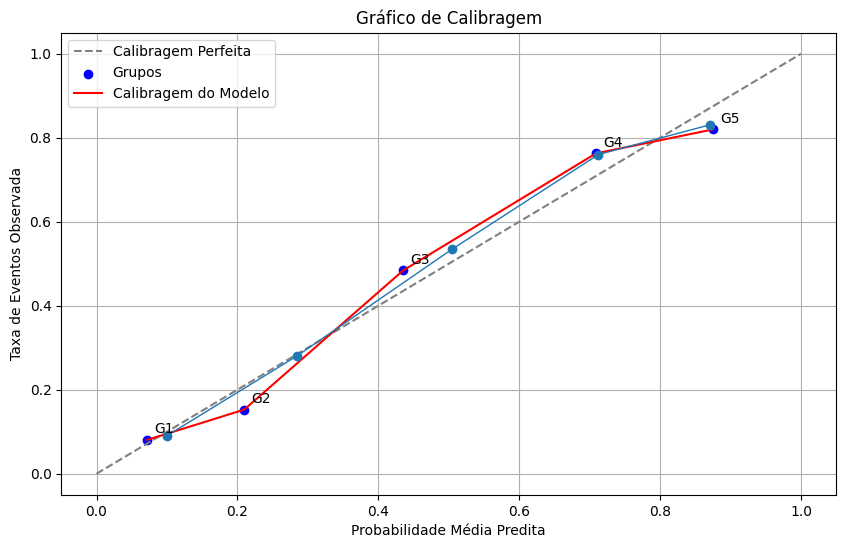


Brier Score: 0.1540
R² da Calibragem: 0.9747


In [7]:

# Calcular as probabilidades preditas
df['prob_predita'] = resultado.predict(df)

# Categorizar as probabilidades em 5 grupos
df['grupo_prob'] = pd.qcut(df['prob_predita'], q=5, labels=['G1', 'G2', 'G3', 'G4', 'G5'])

# Calcular a probabilidade média predita e a taxa de eventos observada por grupo
calibragem = df.groupby('grupo_prob').agg({
    'prob_predita': 'mean',
    'flag_doente': 'mean'
}).reset_index()

calibragem.columns = ['grupo_prob', 'prob_media_predita', 'taxa_eventos_observada']

# Exibir a tabela de calibragem
print("Tabela de Calibragem:")
print(calibragem)

# Criar o gráfico de calibragem
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibragem Perfeita')
plt.scatter(calibragem['prob_media_predita'], calibragem['taxa_eventos_observada'], color='blue', label='Grupos')
plt.plot(calibragem['prob_media_predita'], calibragem['taxa_eventos_observada'], color='red', label='Calibragem do Modelo')

for i, row in calibragem.iterrows():
    plt.annotate(f"G{i+1}", (row['prob_media_predita'], row['taxa_eventos_observada']),
                 xytext=(5, 5), textcoords='offset points')

plt.xlabel('Probabilidade Média Predita')
plt.ylabel('Taxa de Eventos Observada')
plt.title('Gráfico de Calibragem')
plt.legend()
plt.grid(True)

# Adicionar a curva de calibragem usando sklearn
prob_true, prob_pred = calibration_curve(df['flag_doente'], df['prob_predita'], n_bins=5)
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Curva de Calibragem')

plt.show()

# Calcular métricas de calibragem
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(df['flag_doente'], df['prob_predita'])
print(f"\nBrier Score: {brier_score:.4f}")

# Calcular o coeficiente de determinação (R²) para a calibragem
from sklearn.metrics import r2_score

r2 = r2_score(calibragem['taxa_eventos_observada'], calibragem['prob_media_predita'])
print(f"R² da Calibragem: {r2:.4f}")

Acurácia: 0.7954
AUC: 0.8519
Índice GINI: 0.7039
Estatística KS: 0.5930


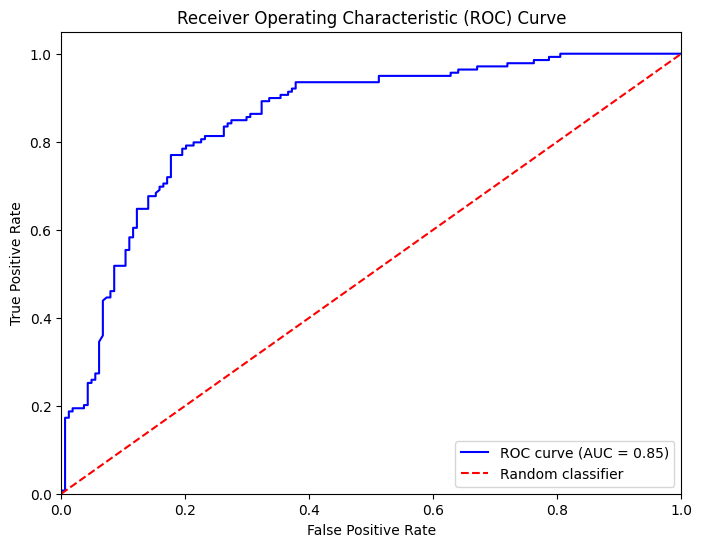

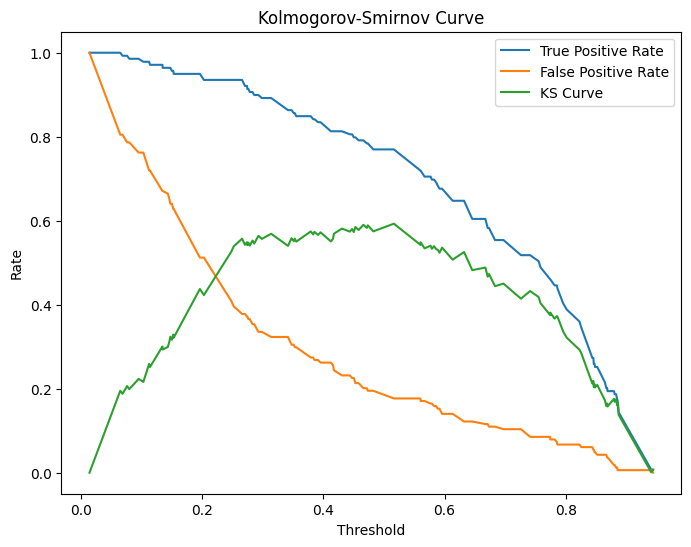

In [8]:

# Calculando as probabilidades preditas (caso ainda não tenha sido feito)
df['prob_predita'] = resultado.predict(df)

# Definindo um ponto de corte (threshold) para classificação binária
threshold = 0.5
df['classe_predita'] = (df['prob_predita'] > threshold).astype(int)

# Calculando a acurácia
accuracy = accuracy_score(df['flag_doente'], df['classe_predita'])

# Calculando a AUC (Area Under the Curve)
auc = roc_auc_score(df['flag_doente'], df['prob_predita'])

# Calculando o índice GINI
gini = 2 * auc - 1

# Calculando a estatística KS
fpr, tpr, thresholds = roc_curve(df['flag_doente'], df['prob_predita'])
ks_statistic = max(tpr - fpr)

# Imprimindo os resultados
print(f"Acurácia: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Índice GINI: {gini:.4f}")
print(f"Estatística KS: {ks_statistic:.4f}")

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plotando a curva KS
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='True Positive Rate')
plt.plot(thresholds, fpr, label='False Positive Rate')
plt.plot(thresholds, tpr - fpr, label='KS Curve')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov Curve')
plt.legend()
plt.show()